# Rewrite Code - Diffusion model
改變：
1. 只有$y_0$從 normal 裡面抽，沒有$x$
2. 'and not DETERMINISTIC' 拿掉
3. 輸出要看到eps

sorce code: Simple file

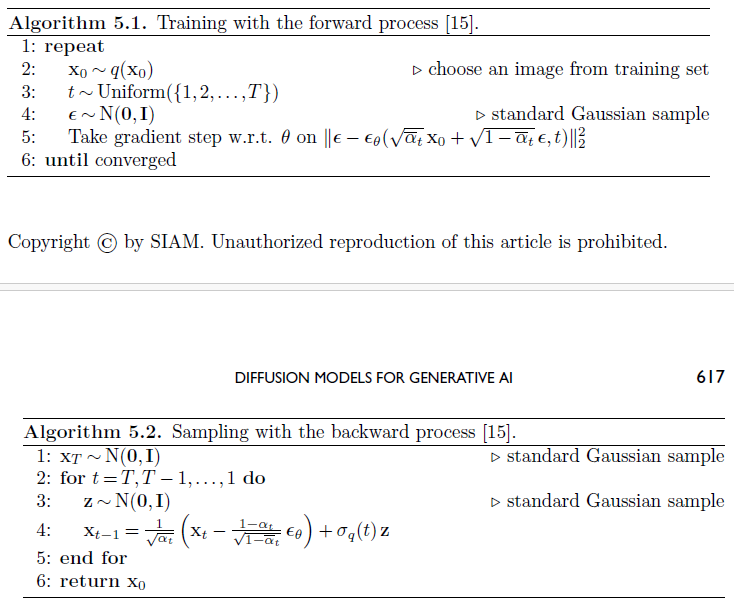


In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

### Con fig

In [2]:
DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 256
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 2e-3
HIDDEN        = 128
TIME_DIM      = 64
N_TRAIN_SAMP  = 4096       # 訓練資料量）


In [3]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [4]:
### 這塊留給 time embedding
### 先不要放試試看

In [6]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.t_proj = nn.Sequential(nn.Linear(time_dim, hidden), nn.SiLU())
        self.net = nn.Sequential(
            nn.Linear(hidden+2, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, x, t):
        h_t = self.proj(t)        ####<<<---這裡t原本要放time embdding
        h = torch.cat([y_t, h_t], dim=1)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

In [7]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps
